# Third floor
## Electricity demand analysis
Throughout this document hourly and daily electricity demand will be analised using different models and methods as seen in Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos (https://otexts.com/fpp2/). The two datasets comprise data for electricity demand observed from the entire third floor of a building, hourly data describe February 2019 while daily observations begin in 2017 and end in february 2019.

## Overview
The following tables contain all the models used and the accuracy achieved ordered by MAPE on the test set.

## Daily forecast

| Model                   |  MAPE |
|-------------------------|-------|
| Dynamic regression      | 6.0   |
| ARIMA(7, 1, 0)(1, 0, 1) |  8.2 |
| STL + ARIMA(1, 1, 1)    |   8.6 |
| ETS(M, Ad, A)           |   8.8 |

This time series is very sparse and hard to predict, all the usual models don't give have very good accuracy:
- Dynamic regression: in this case by far the best model, its accuracy would be even better if it was easier to have reliable open weather data apis, humidity in this case worked well as an external predictor together with some dummy variable;
- ARIMA(7, 1, 0)(1, 0, 1): autocorrelation is strong in electricity demand but in this case sparsity is strong and taking autocorrelation into strong account is not enough.
- STL + ARIMA(1, 1, 1): decomposition itself does not decouple information hidden in the time series very efficiently because the time series is very sparse and seasonality is not remarkably influential on this time series;
- ETS(M, Ad, A): weightin previous observation does not, in general, work well with seasonality and sparsity even if Holt-Winter's method takes seasonality into account;



## Hourly forecast

| Model                    | MAPE |
|--------------------------|------|
| ARIMA(24, 1, 0)(1, 0, 0) |  3.6 |
| ETS(M, Ad, M)            |  7.0 |
| Dynamic regression       |  8.3 |
| STL + ARIMA(3, 1, 2)     |  9.2 |
| TBATS                    | 14.1 |
| MSTL + Random walk       | 17.2 |

This time series is very periodic with a slight trend:
- ARIMA(24, 1, 0)(1, 0, 0): looking at autocorrelation and partial autocorrelation plots ARIMA parameters have been chosen following a standard procedure, described in the aformentioned book, that brought up a very reliable forecast;
- ETS(M, Ad, M): as stated above ETS in general does not work very well for electricity demand time series, the chosen parameters give the best possible accuracy with this model family;
- Dynamic regression: those models have long training times and testing can be hard, this regression can be surely improved through systematic testing and external data availability, such as econometric and weather data;
- STL + ARIMA(3, 1, 2): decomposition does not work well because seasonlity is not the predominant feature and so this kind of model does not bring any benefit;
- TBATS: multiple seasonality, as stated before, does not give any good insight in this series behaviour;
- MSTL + Random walk: multiple seasonal decomposition performs even worse than single seasonal decomposition highlighting the fact that weekly seasonality is completely useless in predicting this time series.


## Installing required packages

In [2]:
install.packages("hts")
install.packages("gridExtra")

Installing package into ‘/home/dpaletti/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

also installing the dependencies ‘farver’, ‘labeling’, ‘munsell’, ‘R6’, ‘RColorBrewer’, ‘viridisLite’, ‘pkgconfig’, ‘xts’, ‘TTR’, ‘curl’, ‘gtable’, ‘isoband’, ‘scales’, ‘tibble’, ‘withr’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘ggplot2’, ‘lmtest’, ‘magrittr’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘forecast’, ‘SparseM’, ‘matrixcalc’, ‘Rcpp’, ‘RcppEigen’




## Parsing
The first step in any analysis is parsing the data, in this case the datasets are written in CSV files where ";" is used as a separator and a header was manually added for easier parsing. Prior to any code block necessary libraries are imported.

In [2]:
library(ggplot2)    # graphics
library(GGally)     # extension for ggplot2
library(gridExtra)  # grid arrangement in plots
library(forecast)   # Hyndman package for time series analysis
library(urca)       # test facilities for differencing
library(httr)       # API interaction
library(rjson)      # json parsing
library(anytime)    # date manipulation facilities
library(timeDate)   # holiday manipulation

In [3]:
hourly <- read.csv(file = "./data/ed_hourly_third.csv", as.is=TRUE, sep=";", header= TRUE)
daily <- read.csv(file="./data/ed_daily_third.csv", as.is=TRUE, sep=";", header=TRUE)

hourly$date <- as.Date(hourly$date, format="%d/%m/%Y-%H")
daily$date <- as.Date(daily$date, format="%d/%m/%Y")

## Single seasonality time series definition and plotting
The basic facililty in forecast package for representing time series is the ts object, a time series object with one possible seasonality. In order to test the accuracy of the forecasting models the time series has to be split in training and test data, hourly data needs a 24 hour forecasting so a 24 hour test set will be created, daily data needs a one week forecasting so a one week test set will be created. 

In [4]:
daily.ts <- ts(daily$ed, frequency=7)
#> start=c(1, 1) 
#> end=c(103, 5)

hourly.ts <- ts(hourly$ed, frequency=24)
#> start=c(1, 1)
#> end=c(28, 22)

daily.train <- window(daily.ts, end=c(102, 5))
daily.test <- window(daily.ts, start=c(102, 5))

hourly.train <- window(hourly.ts, end=c(27, 22))
hourly.test <- window(hourly.ts, start=c(27, 22))

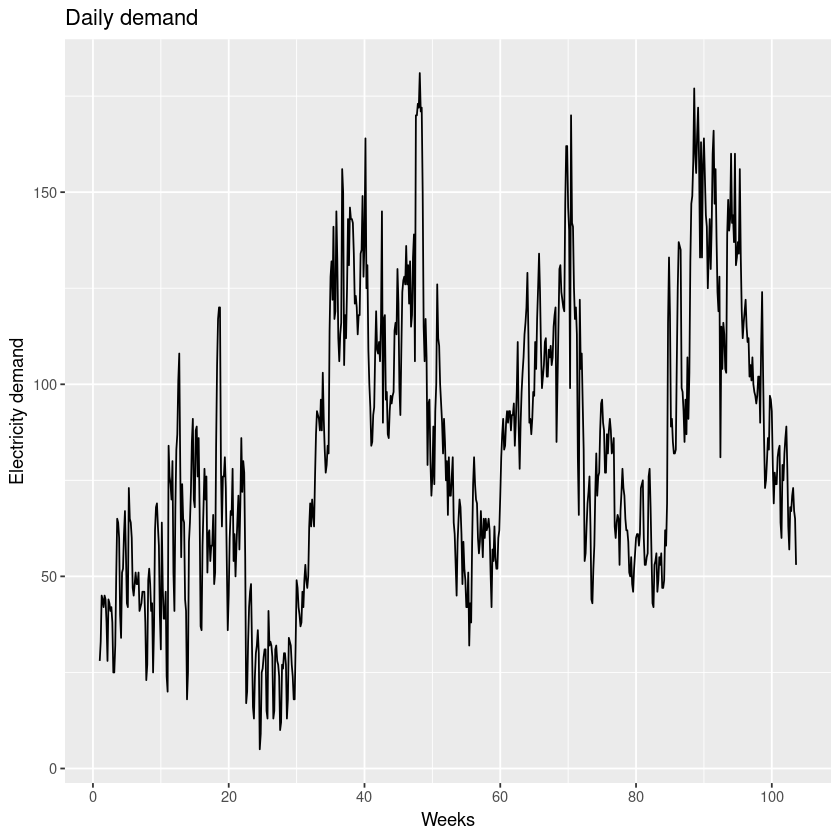

In [13]:
autoplot(daily.ts) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    ggtitle("Daily demand")

This time series looks pretty sparse from the plot by itself, weekly seasonality is for sure there and probably with a longer series one would see a clear yearly seasonality, there is probably a slightly significant trend component.

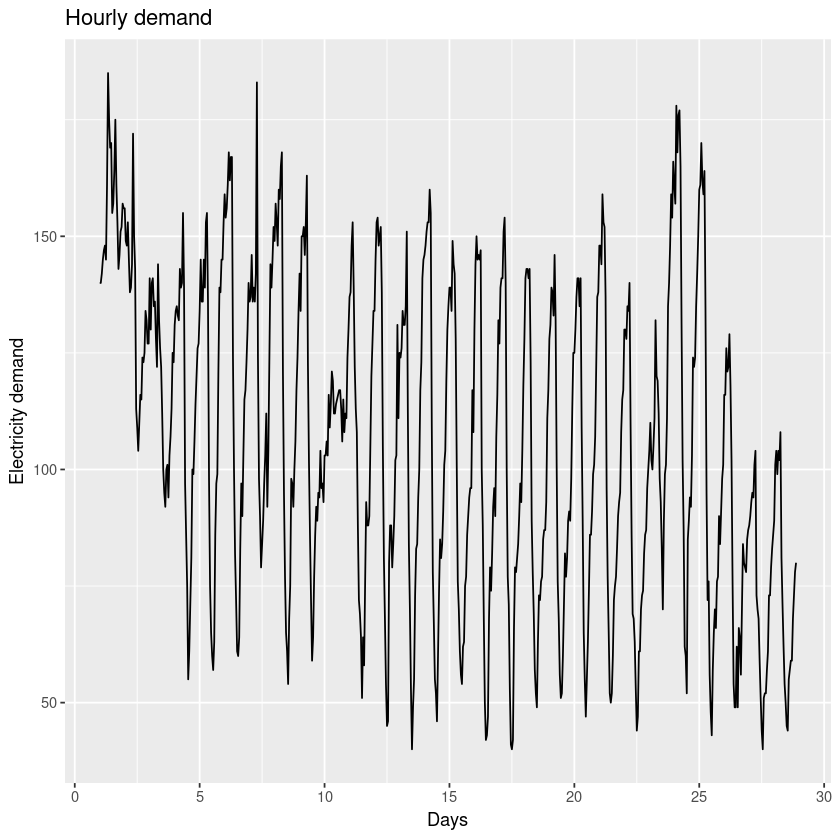

In [14]:
autoplot(hourly.ts) +
    xlab("Days") +
    ylab("Electricity demand") +
    ggtitle("Hourly demand")

Daily seasonality is very strong in this plot, there is no clear plot and no other clear seasonality. One would expect a weekly seasonality that does not seem to be visible from this plot.

## Decomposition
The method chosen for time series decomposition is STL (Seasonal and trend decomposition using Loess) mainly because it handles any seasonality and not only quarterly or monthly, which the previous datasets do not show. Moreover STL can be robust to outliers so that they will not affect trend-cycle or seasonal component but only the remainder. The two main parameters to be chosen when usin STL decomposition are the trend-cycle window 't.window' and the seasonal window 's.window', that can be set to infinite with "periodic". When using mstl() s.window is set to 13 and t.window is automatically set.
In daily demand we see that the seasonal component does not change with trend and that the remainder does not contain much information, this means that probably the ts object leveraging only weekly seasonality correctly describes the dataset.
In hourly demand we see that seasonality is changing with time and that the remainder still contains a lot of information, this may point that another seasonality should be taken into account in order to have a complete description of the datasets

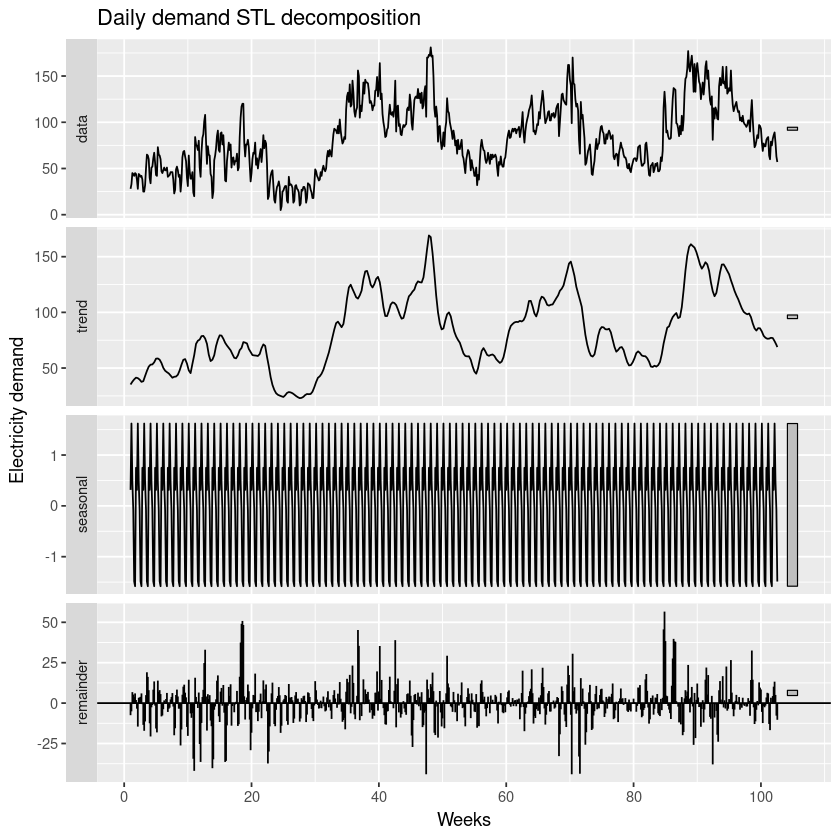

In [139]:
daily.train.stl <- stl(daily.train, t.window=13, s.window="periodic", robust=TRUE)
    autoplot(daily.train.stl) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    ggtitle("Daily demand STL decomposition")


The remainder component seems to be fairly eavenly distributed along all the time series, it does not seem to be very significant. From this analysis one may say that not much information is left in the time series other than the weekly seasonality and so a monthly seasonality is probably to roll out.

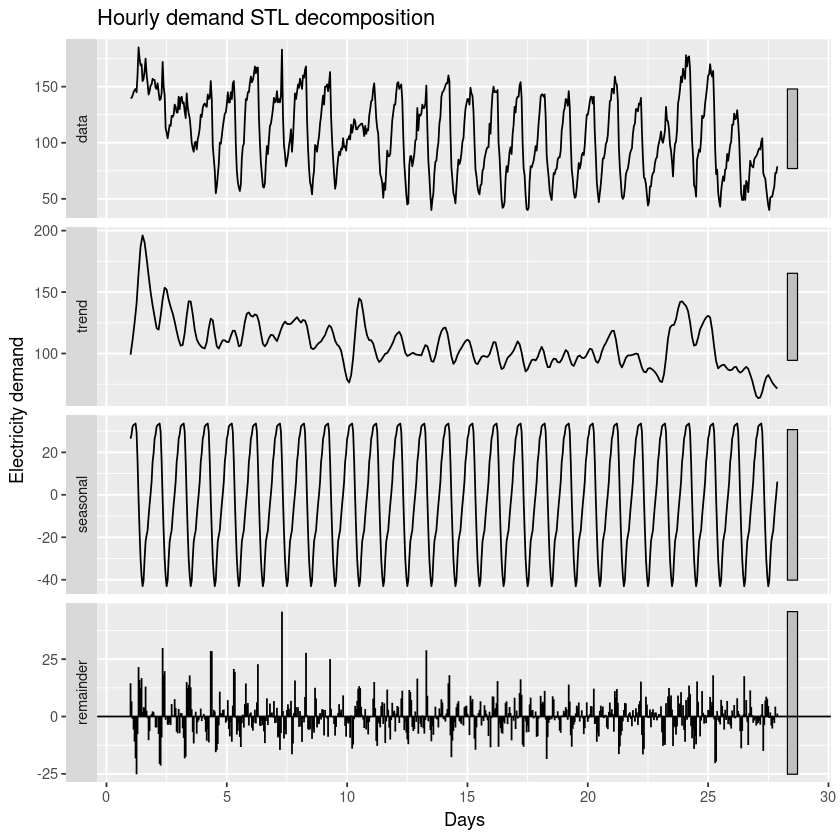

In [16]:
hourly.train.stl  <- stl(hourly.train, t.window=13, s.window="periodic")
    autoplot(hourly.train.stl) +
    xlab("Days") +
    ylab("Electricity demand") +
    ggtitle("Hourly demand STL decomposition")

This decomposition shows a decreasing trend that did not show up that clearly in the time plot. The remainder is evenly distributed and does not show much information left, one could later try leveraging weekly seasonality but the benefits are not expected to be that remarkable.

### Naive forecast of seasonally adjusted component and reseasonalization
One possible approach to forecasting is decomposing the time series in seasonally adjusted component, that is the time series without its seasonal component, and seasonal component, forecast those indipendently and then add the forecasts up to obtain the forecast for the chosen time series.
A naive forecast, or random walk forecast, is being used to forecast the seasonally adjusted component and then through the forecast function the forecast is reseasonalized.
Naive: $$\hat{y}_{T + h | T} = y_T$$
Accuracy from now on will be calculated over the training and the test set using accuracy().

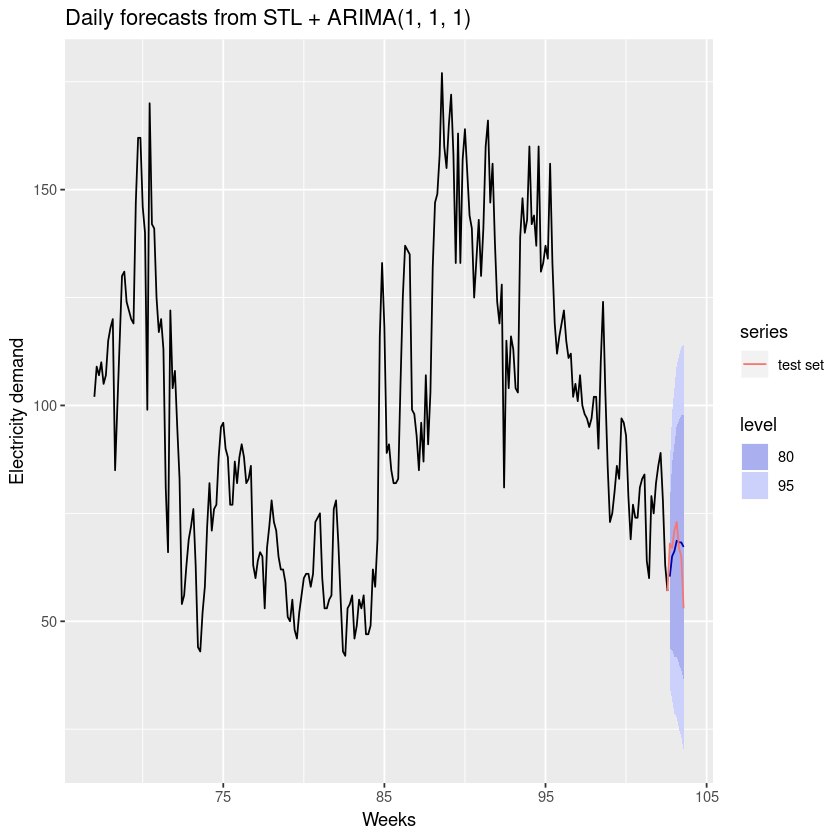

In [30]:
#daily
daily.fc.stl <- forecast(daily.train.stl,method="arima", h=7)
autoplot(daily.fc.stl, include = 250) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(daily.test, series="test set") +
    ggtitle("Daily forecasts from STL + ARIMA(1, 1, 1)")

In [26]:
accuracy(daily.fc.stl, daily.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.128802003,13.033926,9.314402,-3.3349498,14.169930,0.4957836,0.03265793,NA
Test set,-0.009336793,6.741564,5.350763,-0.9931594,8.651178,0.2848085,0.28252479,1.139394


Both MAPEs are really high, the accuracy of the forecast is not that good and the prediction intervals are pretty wide. ARIMA for forecasting the seasonal adjusted component is by far the best model as it leverages autocorrelation that even in a sparse time series like this is still clearly present.

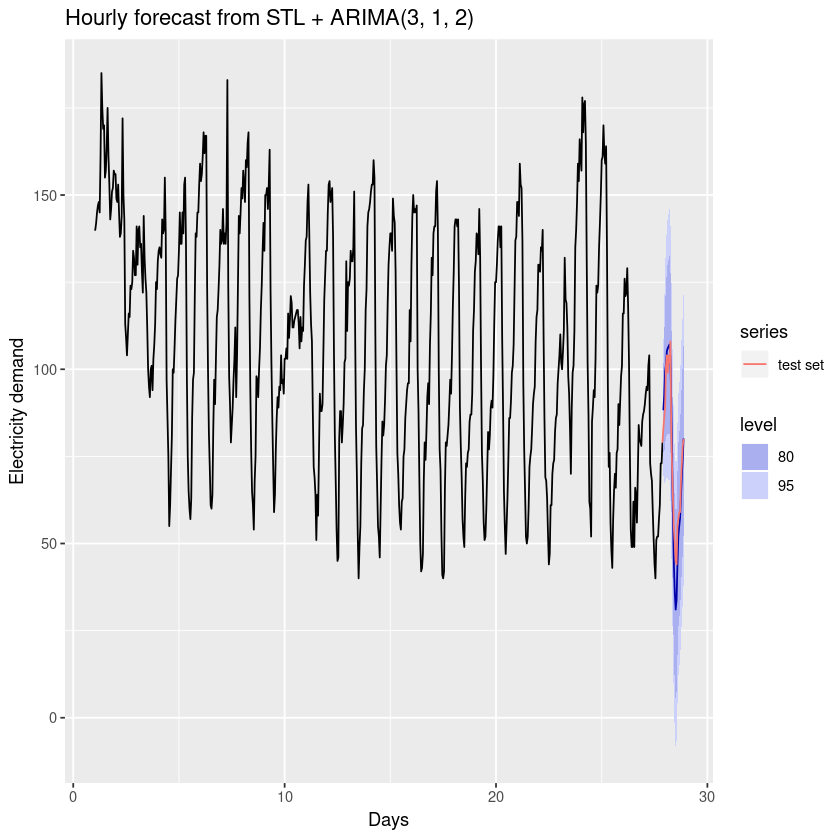

In [40]:
#hourly
hourly.fc.stl <- forecast(hourly.train.stl, method="arima", h=24)
autoplot(hourly.fc.stl) +
    xlab("Days") +
    ylab("Electricity demand") +
    autolayer(hourly.test, series="test set") +
    ggtitle("Hourly forecast from STL + ARIMA(3, 1, 2)")

In [41]:
accuracy(hourly.fc.stl, hourly.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.291983,9.331401,6.763447,-0.9060575,6.727906,0.4193027,0.0001502082,NA
Test set,1.817220,7.070213,5.817066,4.7901473,9.259884,0.3606314,0.6808415809,1.180964


Accuracy of the forecast is remarkably low, this is due to the fact that the series does not show any clear pattern that can be leveraged for increasing accuracy by decomposing the series.

## Exponential smoothing
Forecast made with exponential smoothing use a weighted average of past observation with weights decaying exponentially as observations get older. In order to forecast data with seasonality we must use an extension of the Simple exponential smoothing(SES) model, that cannot take into account neither seasonality nor trend, called Holt-Winter's method. 
In general the (T+1)-th osbservation in SES is $y_{T+1|T} = \alpha y_T + (1 - \alpha)\hat{y}_{T | T - 1}$.
SES can be described through a component form
\begin{align*}
  \text{Forecast equation}  && \hat{y}_{t+h|t} & = \ell_{t}\\
  \text{Smoothing equation} && \ell_{t}        & = \alpha y_{t} + (1 - \alpha)\ell_{t-1},
\end{align*}
Parameters $\alpha, l_0$ need to be estimated.  
SES is then extended to support trend, this is called Holt's method:
\begin{align*}
  \text{Forecast equation}&& \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} \\
  \text{Level equation}   && \ell_{t} &= \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation}   && b_{t}    &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1},
\end{align*}
Then Holt-Winter's additive method is obtained by adding a seasonality equation:
\begin{align*}
  \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}
Holt-Winter's method has multiplicative version too:
\begin{align*}
  \hat{y}_{t+h|t} &= (\ell_{t} + hb_{t})s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha \frac{y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1}                \\
  s_{t} &= \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}
\end{align*}
In all the previous model it is possible to introduce a parameter for damping the trend, ES methods that take into account trend tend to overforcast because they extend trend infinitely into the future.
In order to generate prediction intervals innovative state space models are used.
In general an exponential smoothing model is ETS(X, Y, Z) where:
- X can be either M, for multiplicative errors, or A, for additive errors, or N for no errors, so a point forecast.
- Y can be either none, additive, or additive damped (Ad), referring to trend estimation;
- Z for seasonality can be either, none, additive or multiplicative.  
The ets() function automatically chooses a model by minimising AIC (Aikake's information Criterion)

In [80]:
#daily
daily.fit.ets <- ets(daily.train, damped=TRUE, model="MZA")

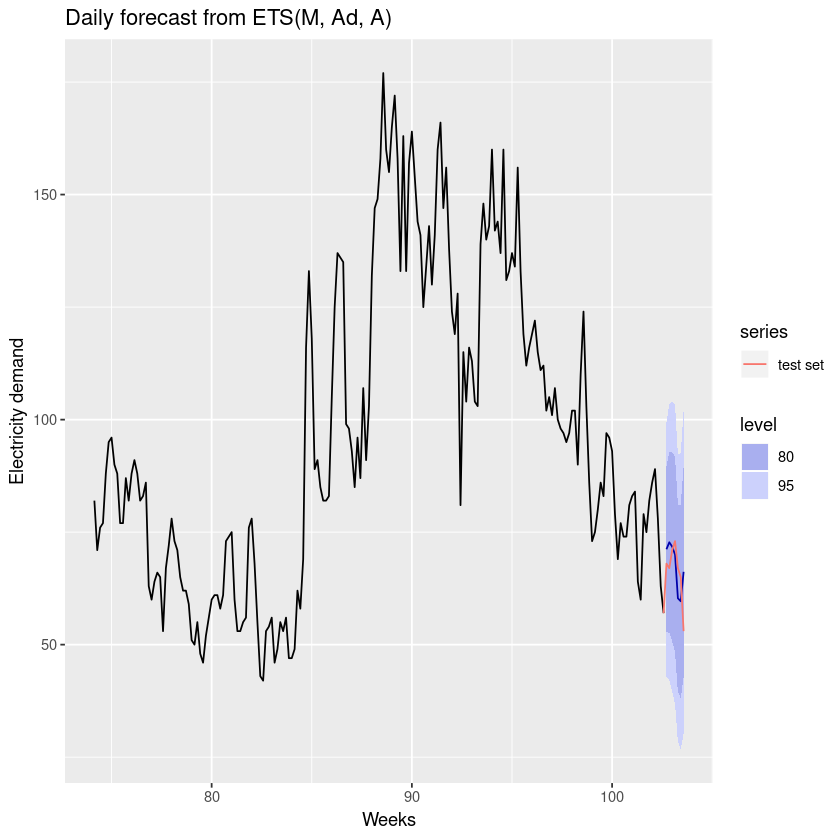

In [103]:
#daily
daily.fc.ets <- forecast(daily.fit.ets, h=7)
autoplot(daily.fc.ets, include = 200) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(daily.test, series ="test set") +
    ggtitle("Daily forecast from ETS(M, Ad, A)")

In [82]:
#daily
accuracy(daily.fc.ets, daily.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.05183921,14.990779,11.282779,-3.412403,16.049731,0.6005556,0.45657278,NA
Test set,-1.11851930,6.548885,5.423297,-2.409935,8.800131,0.2886692,0.04824163,1.185039


The forecast has pretty low accuracy, one of the reasons is that this model does not deal that well with autocorrelation and seasonality. Parameter have been chosen minimising the MAPE taking into account the fact that a slight trend can be leveraged and that seasonality seems to be better modelled with Additive rather than Multiplicative estimation.

In [99]:
#hourly
hourly.fit.ets <- ets(hourly.train, damped=TRUE, model="MAZ")

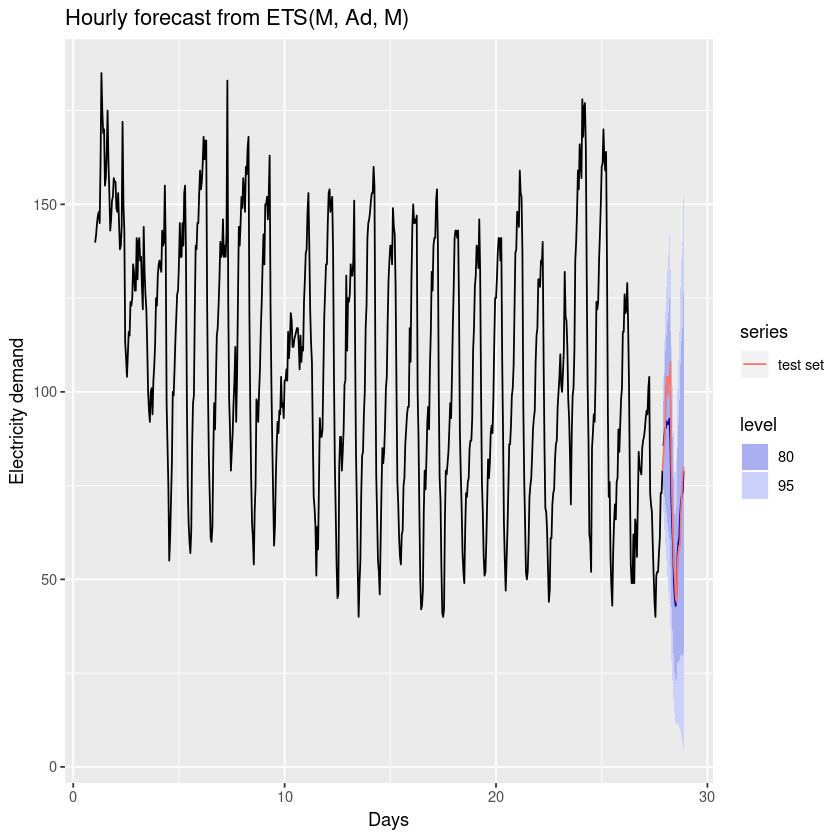

In [104]:
#hourly
hourly.fc.ets <- forecast(hourly.fit.ets, h=24)
autoplot(hourly.fc.ets) +
    xlab("Days") +
    ylab("Electricity demand") +
    autolayer(hourly.test, series ="test set") +
    ggtitle("Hourly forecast from ETS(M, Ad, M)")

In [95]:
#hourly
accuracy(hourly.fc.ets, hourly.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.02008238,10.483123,7.325271,-0.6593063,7.188384,0.4541332,0.1326209,NA
Test set,3.51054404,7.393917,5.601690,3.5649236,6.983939,0.3472791,0.6560422,0.8041814


This prediction has low accuracy when considering the MAPE on the test set. ETS models are not well suited for this kind of time series we can actually see that giving too much relevance to near values can be quit damaging when predicting on this kind of test set.

## Autoregressive integrated moving average (ARIMA)
In an autoregressive model we forecast future observation using a linear combination of past observations, an autoregressive model of order p AR(p) can be written as $$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$$
that is like a multiple regression model but with lagged values of y. Usually AR models are restricted to stationary, non trending nor seasonal, timeseries. Moving average models MA(q) rather than using past observations use past errors in a linear combination $$y_{t} = c + \varepsilon_t + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q}$$
By combining AR and MA we obtain a non seasonal ARIMA model
$$y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p} + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$$
where $y'_t$ is the differenced series, that is $y'_t = y_t - y_{t - 1}$ for degree one first differencing . The previous model is called an ARIMA(p,d, q) model where p is the order of AR, d is the order of first differencing and q is the order of MA.  
As a first step an autocorrelation and partial autocorrelation plot is useful for understanding which kind of ARIMA model one needs. Autocorrelation indicates the correlation between an observation and the ones before, partial autocorrelation removes the effect of the previous observation from the calculation.
Both hourly and daily data show seasonality so an ARIMA seasonal model needs to be used where (p, d, q) are the same of a non seasonal model and (P, D, Q)m are introduced for the seasonal part of the model, where m is the number of observations per year. The seasonal part of the model is similar to the non seasonal part but includes backshifting of the seasonal period

In [187]:
#daily
daily.fit.arima <- Arima(daily.train, order=c(7, 1, 0), seasonal=c(1, 0, 1))

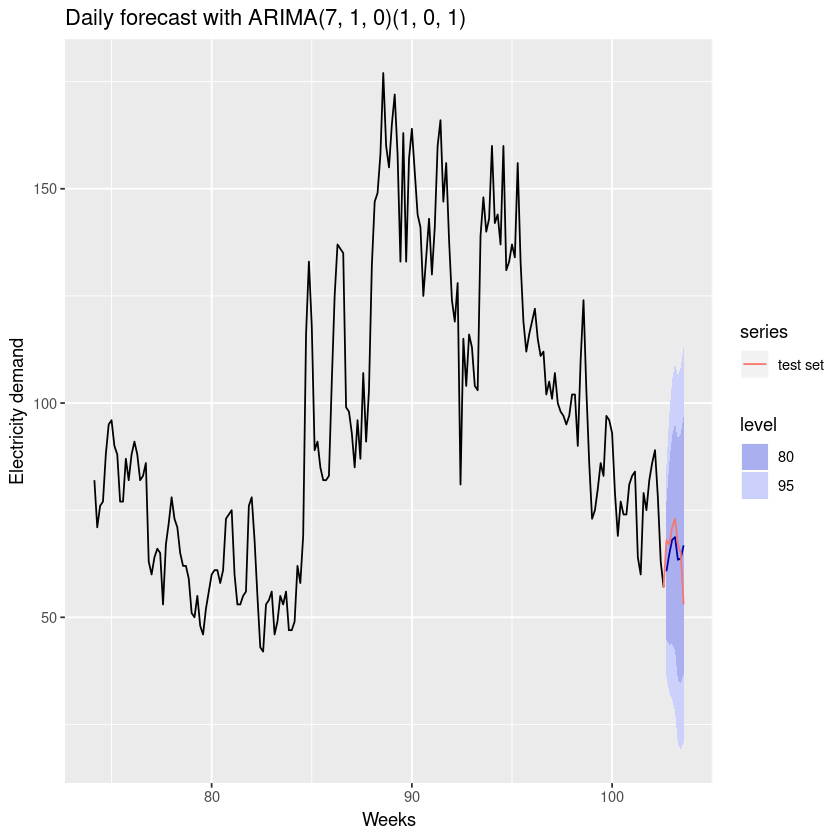

In [188]:
#daily
daily.fc.arima <- forecast(daily.fit.arima, h=7)
autoplot(daily.fc.arima, include=200) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(daily.test, series="test set") +
    ggtitle("Daily forecast with ARIMA(7, 1, 0)(1, 0, 1)")

In [189]:
#daily
accuracy(daily.fc.arima, daily.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1279197,12.481781,8.973660,-2.5697649,12.792168,0.4776467,-0.009928218,NA
Test set,1.0959728,6.424377,5.037123,0.7341074,8.170239,0.2681141,0.072939334,1.083472


ARIMA leverages autocorrelation in the model hence it works well with electricity demand time series that show strong autocorrelation:

In [15]:
daily.ts %>% #2.4961 ur test statistics
    diff() %>%
        ur.kpss()


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0473 


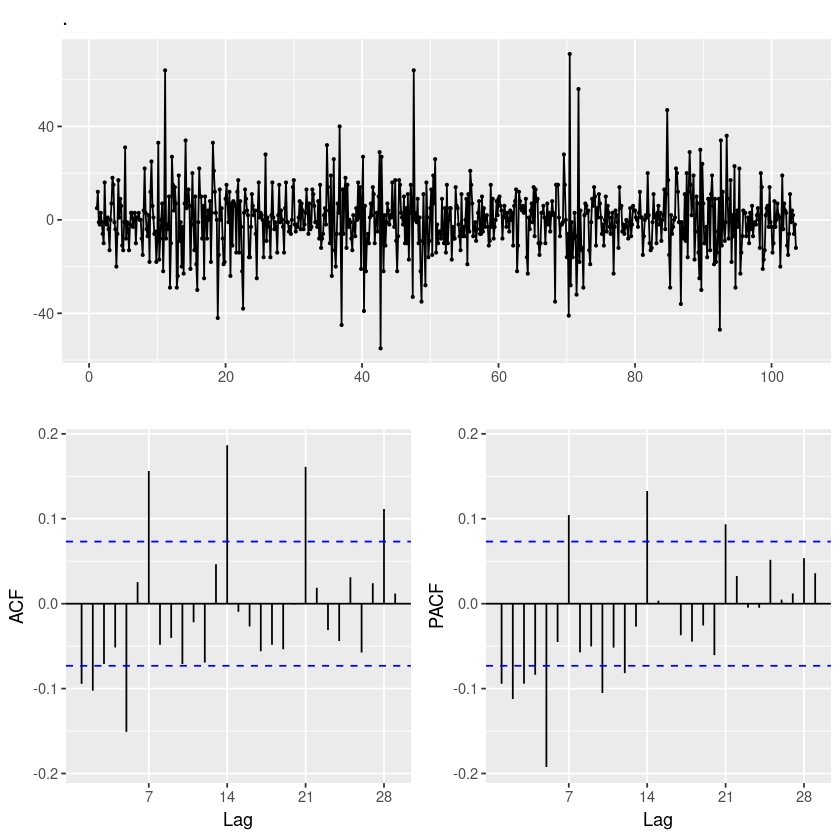

In [45]:
diff(daily.ts, differences=1) %>% ggtsdisplay()
#standard deviation diff(daily.ts): 13.39
#standard deviation diff(daily.ts, differences=2): 19.81

After differencing the first time the KPS unit root test shows that no further differencing is needed together with the fact that the standard deviation of the two times differenced series is higher than the one time differenced series. The base model is ARIMA(0, 1, 0)(0, 0, 0) some tweaking of the parameters trying to minimize the MAPE brings up ARIMA(7, 1, 0)(1, 0, 1)

In [10]:
#hourly
hourly.fit.arima <- Arima(hourly.train, order=c(24, 1, 0), seasonal=c(1, 0, 0))

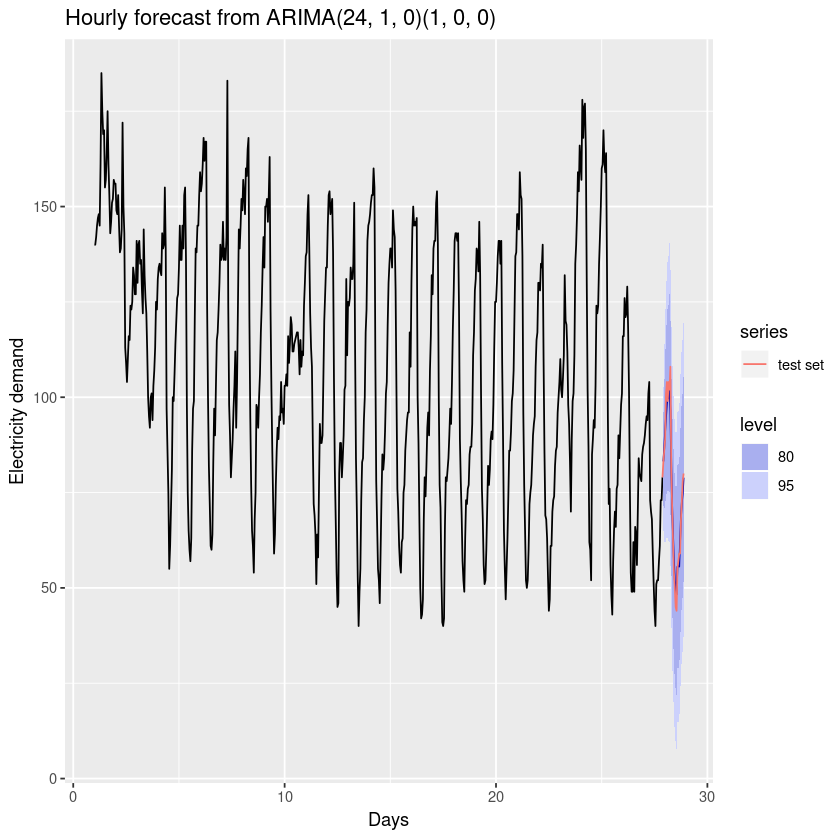

In [37]:
#hourly
hourly.fc.arima<- forecast(hourly.fit.arima, h=24)
autoplot(hourly.fc.arima) +
    xlab("Days") +
    ylab("Electricity demand") +
    autolayer(hourly.test, series="test set") +
    ggtitle("Hourly forecast from ARIMA(24, 1, 0)(1, 0, 0)")

In [38]:
#hourly
accuracy(hourly.fc.arima, hourly.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.3920885,8.812059,6.523724,-1.0551245,6.641659,0.4044410,-0.02049042,NA
Test set,0.5196235,3.695413,2.608433,-0.1981487,3.609906,0.1617109,0.12821535,0.4698098


In [31]:
ur.kpss(diff(hourly.ts))


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0058 


In [30]:
ur.kpss(hourly.ts)


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.3575 


Test statisitics is heavily influenced so first order differencing is chosen

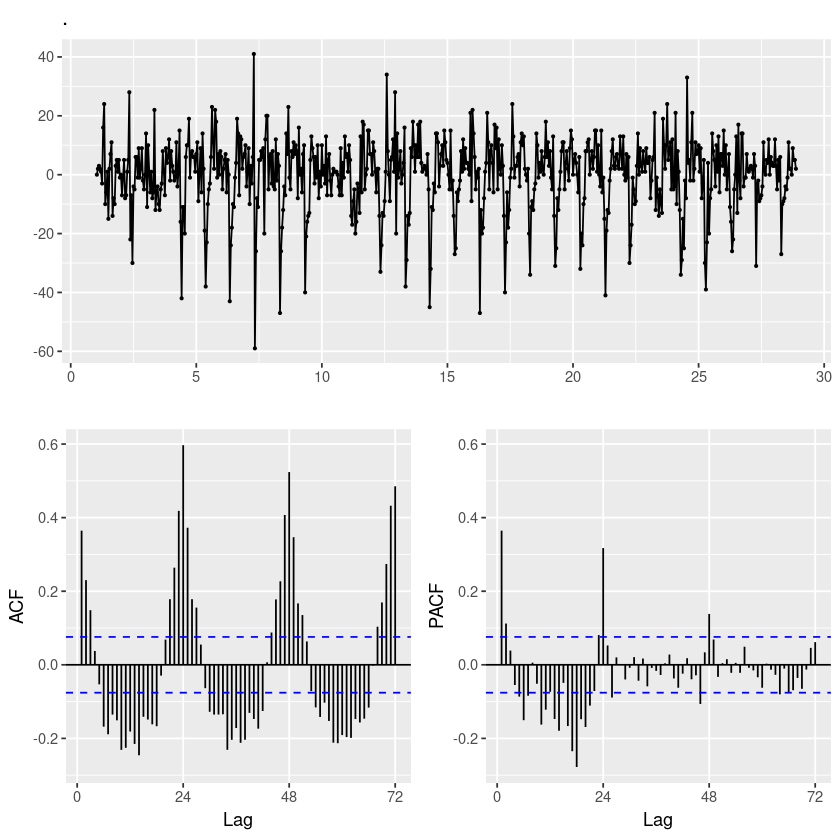

In [53]:
diff(hourly.ts) %>% ggtsdisplay()

The ACF is sinusoidal and in the PACF there are two significant spikes, to account for them the non seasonal AR is set to 24 while the seasonal AR to 1. Considering first order differencing ARIMA(24, 1, 0)(1, 0, 0) is chosen. 

## Complex seasonality
High frequency time series often show multiple seasonality. As shown in the STL decomposition the hourly dataset is not fully described with a daily seasonality and so the use of multiple seasonality models involving weekly seasonality along daily seasonality is expected to be beneficial to forecast accuracy. The daily dataset would probably show a yearly seasonality if it were a longer series but two seasons are not enough to leverage seasonality.

In [16]:
hourly.msts <- msts(hourly$ed, seasonal.periods = c(24, 168))
#> start=c(1, 1)
#> end=c(4, 166)
hourly.msts.train <- window(hourly.msts, end=c(4, 142))
hourly.msts.test <- window(hourly.msts, start=c(4, 142))

### STL decomposition
The mstl() function is a variation on the stl() function to deal with multiple seasonality, it shows all the seasonal components in one go. The plot shows a less significant remainder component as expected.

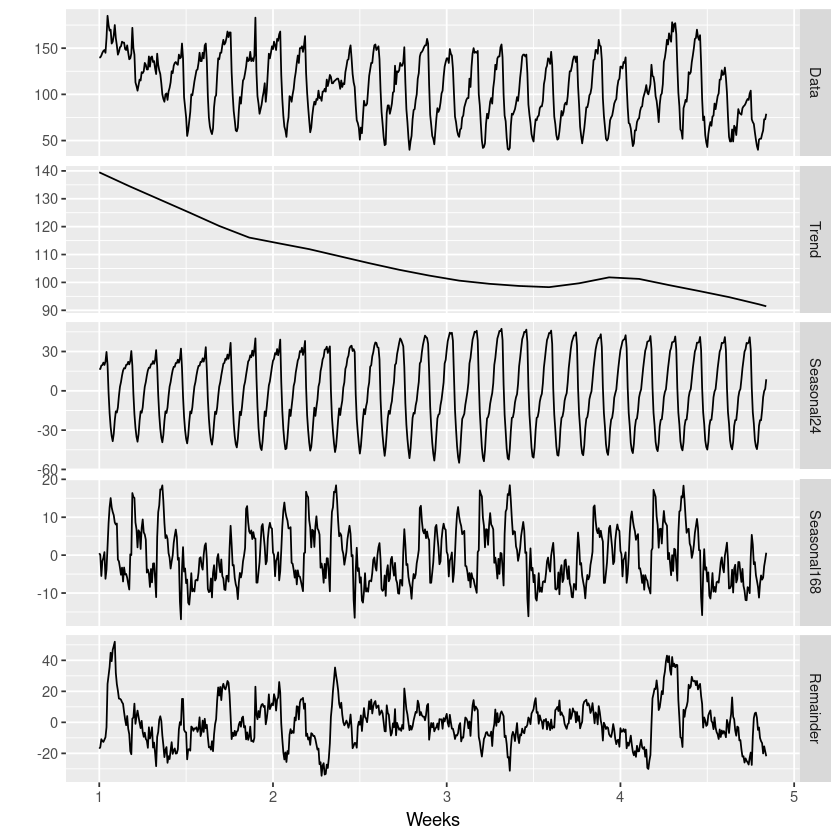

In [17]:
hourly.msts.train.mstl <- mstl(hourly.msts.train)
autoplot(hourly.msts.train.mstl) +
    xlab("Weeks")

The remainder component is remarkably relevant but now the trend is clearly plotted in the second subplot. This decomposition will not be particularly useful as the weekly seasonality is not that strong.

### Forecasting with decomposition
The stlf() function allows easy forecasting for a decomposed series, a seasonal naive method is applied to the seasonal components and the seasonally adjusted data is forecasted with a user specified method, in this case an ARIMA model.

In [31]:
hourly.msts.fc.stlf <- stlf(hourly.msts.train, h=24, method="naive")

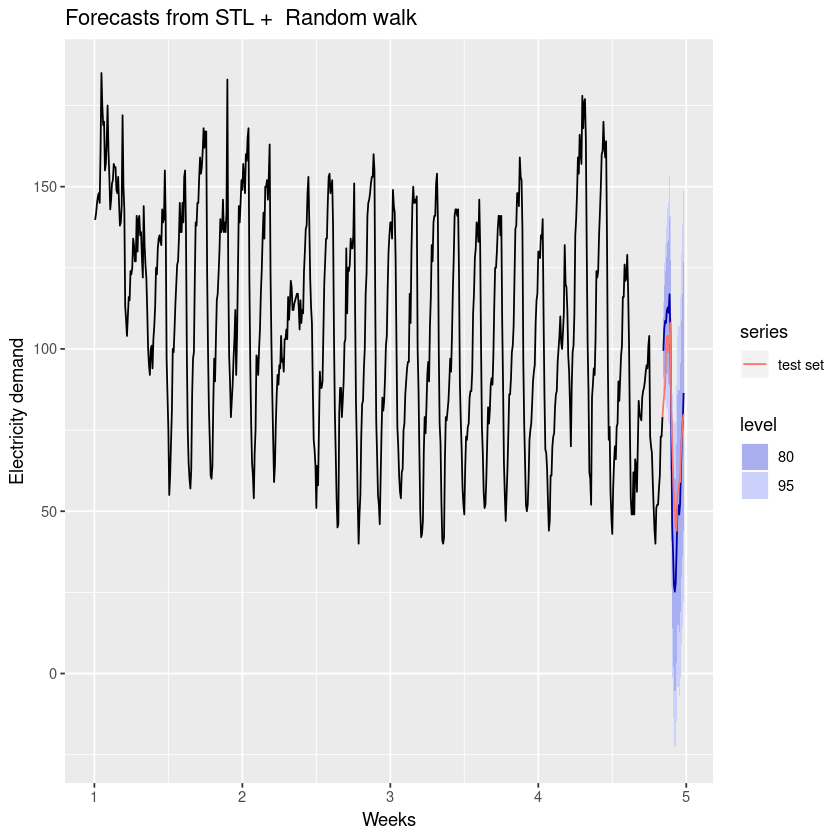

In [32]:
autoplot(hourly.msts.fc.stlf) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(hourly.msts.test, series="test set")
    ggtitle("Hourly forecast with STL + Random walk")

In [33]:
accuracy(hourly.msts.fc.stlf, hourly.msts.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.08210845,6.622211,4.922801,-0.3436321,5.041134,0.2439456,-0.06982259,NA
Test set,2.12231419,14.183997,11.590127,6.8950202,17.194076,0.5743397,0.81658882,1.973149


This model gives very poor results due to a bad decomposition where weekly seasonality is used even if it does not welll describe the series.

### TBATS
A TBATS model uses a combination of Fourier terms, BoxCox transformation and exponential smoothing in a completely automated manner. In TBATS models the seasonality is allowed to slightly change overtime.

In [34]:
hourly.msts.fit.tbats <- tbats(hourly.msts.train)

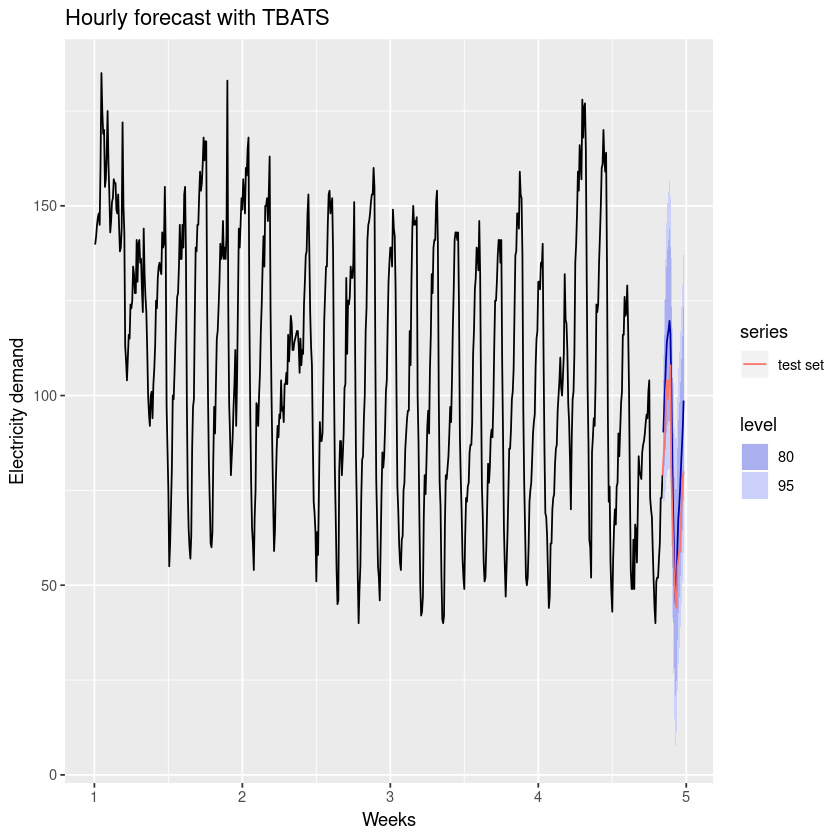

In [35]:
hourly.msts.fc.tbats <- forecast(hourly.msts.fit.tbats, h=24)
autoplot(hourly.msts.fc.tbats) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(hourly.msts.test, series="test set") +
    ggtitle("Hourly forecast with TBATS")

In [36]:
accuracy(hourly.msts.fc.tbats, hourly.msts.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.6797554,9.255705,6.742375,-1.361002,6.762001,0.3341131,-0.003718908,NA
Test set,-11.0898065,12.284144,11.091421,-14.604217,14.607446,0.5496267,0.457530422,1.538263


As this model further remarks the hourly series is not well described using multiple seasonality.

## Dynamic regression models
Dynamic regression models allow including additional information like holidays and temperatures while still considering autocorrelation the same way ARIMA models do. In general the error term $\eta_t$ is calculated through an ARIMA model so we have a linear regression model like 
$$y_t = \beta_0 + \beta_1 x_{1,t} + \dots + \beta_k x_{k,t} + \eta_t,$$
and, for example, if $eta_t$ follows an ARIMA(1, 1, 1) model
$$(1-\phi_1B)(1-B)\eta_t = (1+\theta_1B)\varepsilon_t$$
where $\varepsilon_t$ is a white noise series, that is the ARIMA model error.
Temperatures will be used as external predictors, data is downloaded from DarkSky.net . The prediction for electricity demand is to be done for a building in Bergamo, Italy.

### Hourly data
Predictors choiche is based on https://robjhyndman.com/publications/stlf/.  
Chosen predictors:¶
- electricity demand a hour before
- electricity demand a day before
- electricity demand 2 days before
- maximum demand in the last 24 hours
- minimum demand in the last 24 hours
- average demand in the last 7 days
- day of the week  
The code for API querying has been disabled because the data has been stored on a CSV file.

In [150]:
#lag function
custom_lag <- function(x, k){
    y <- vector()
    y[seq(k)] <- 0
    for(j in seq(from=k+1, to=length(x)))
        y[j] <- x[j-k]
     y <- ts(y, frequency=frequency(x))
    return(y)
}


#demand

#one hour lag
hourly.train.lag1 <- custom_lag(hourly.train, 1)

#one day lag
hourly.train.lag24 <- custom_lag(hourly.train, 24)

#two days lag
hourly.train.lag48 <- custom_lag(hourly.train, 48)

#maximum demand
hourly.train.max <- vector()
for(j in seq(hourly.train))
    hourly.train.max[j] <- max(hourly.train[seq(from=max(1, j - 24), to=j)])

#minimum demand
hourly.train.min <- vector()
for(j in seq(hourly.train))
    hourly.train.min[j] <- min(hourly.train[seq(from=max(1, j - 24), to=j)])

#mean demand
hourly.train.mean <- vector()
for(j in seq(hourly.train))
    hourly.train.mean[j] <- mean(hourly.train[seq(from=max(1, j - 24), to=j)])

#day of the week predictors
monday <- vector()
tuesday <- vector()
wednesday <- vector()
thursday <- vector()
friday <- vector()
saturday <- vector()
for(j in seq(hourly.train)){
    monday[j] <- 0
    tuesday[j] <- 0
    wednesday[j] <- 0
    thursday[j] <- 0
    friday[j] <- 0
    saturday[j] <- 0
    if(format(hourly$date[j], "%A") == "Monday")
        monday[j] <- 1
    if(format(hourly$date[j], "%A") == "Tuesday")
        tuesday[j] <- 1
    if(format(hourly$date[j], "%A") == "Wednesday")
        wednesday[j] <- 1
    if(format(hourly$date[j], "%A") == "Thursday")
        thursday[j] <- 1
    if(format(hourly$date[j], "%A") == "Friday")
        friday[j] <- 1
    if(format(hourly$date[j], "%A") == "Saturday")
        saturday[j] <- 1
}

In [40]:
#model fitting
xreg <- cbind(hourly.train.lag1 = hourly.train.lag1,
              hourly.train.lag24 = hourly.train.lag24,
              hourly.train.lag48 = hourly.train.lag48,
              hourly.train.max = hourly.train.max,
              hourly.train.min = hourly.train.min,
              hourly.train.mean = hourly.train.mean,
              monday = monday,
              tuesday = tuesday,
              wednesday = wednesday,
              thursday = thursday,
              friday = friday,
              saturday = saturday)
hourly.fit.reg <- auto.arima(hourly.train, xreg=xreg)

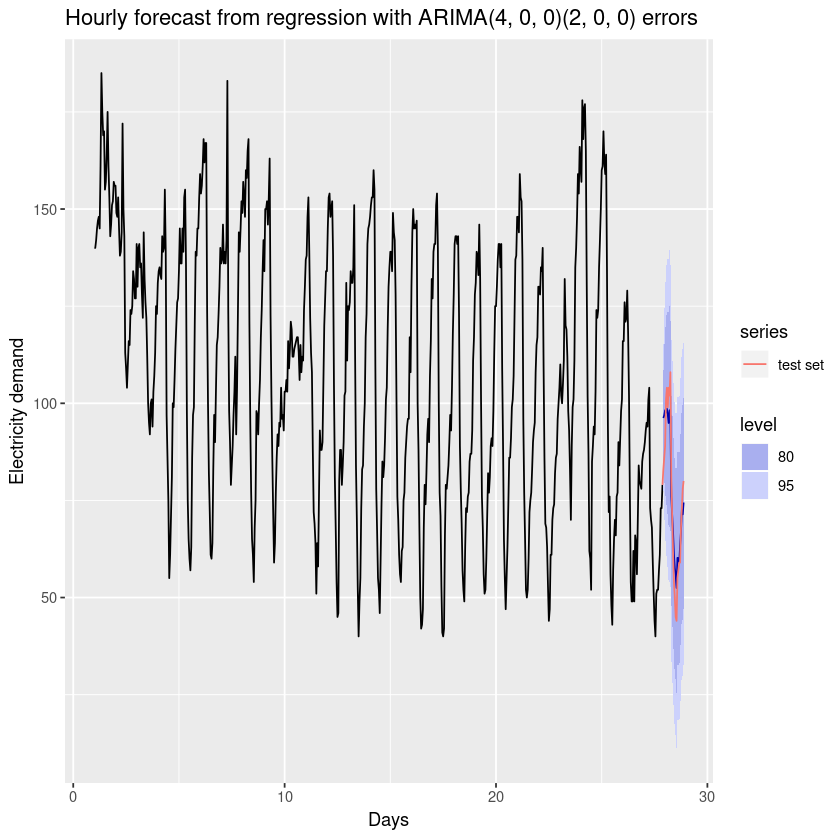

In [47]:
hourly.fc.reg <- forecast(hourly.fit.reg, xreg=tail(xreg, 24))
autoplot(hourly.fc.reg) +
    xlab("Days") +
    ylab("Electricity demand") +
    autolayer(hourly.test, series="test set") +
    ggtitle("Hourly forecast from regression with ARIMA(4, 0, 0)(2, 0, 0) errors")
    #ggtitle("Hourly forecast with Regression and ARIMA(2, 0, 2)(1, 0, 0) errors")

In [46]:
accuracy(hourly.fc.reg, hourly.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1453761,8.750907,6.427582,-0.580415,6.503286,0.3984806,-0.01369696,NA
Test set,-1.3057169,6.847444,5.783681,-3.482979,8.267051,0.3585617,0.66319296,0.9131511


This model leverages many useful predictors but it has quite high training times. The prediction is nowhere near the accuracy of a correctly tweaked ARIMA model but it has much room for improvement.

### Daily Data

A research paper for daily electricity demand in South Africa (https://mafiadoc.com/daily-electricity-demand-forecasting-in-south-africa-academic-journals_5b251d6e097c47b24c8b4585.html) is used as a guide for choosing predictors, on top of those two weather predictors, windspeed and humidity, are also added to increase accuracy.
Chosen predictors:
- month (dummy variable)
- day of the week (dummy variable)
- holiday , day after and before any holiday (dummy variable)
- windspeed
- humidity

In [258]:
#reading humidity from previously created data set
daily.humidity <- read.csv(file = "./dati_forecasting/daily_humidity.csv", as.is=TRUE, sep=",", header= TRUE)
daily.humidity.ts <- ts(daily.humidity$humidity.humidity, frequency=7)
daily.humidity.train <- window(daily.humidity.ts, end=c(102, 5))

In [229]:
#one day lag
daily.train.lag1 <- custom_lag(daily.train, 1)

#dummy variables

#day of the week predictors
daily.monday <- vector()
daily.monday[seq(daily.train)] <- 0
daily.monday[format(daily$date[seq(daily.train)], "%A") == "Monday"] <- 1

daily.tuesday <- vector()
daily.tuesday[seq(daily.train)] <- 0
daily.tuesday[format(daily$date[seq(daily.train)], "%A") == "Tuesday"] <- 1

daily.wednesday <- vector()
daily.wednesday[seq(daily.train)] <- 0
daily.wednesday[format(daily$date[seq(daily.train)], "%A") == "Wednesday"] <- 1

daily.thursday <- vector()
daily.thursday[seq(daily.train)] <- 0
daily.thursday[format(daily$date[seq(daily.train)], "%A") == "Thursday"] <- 1

daily.friday <- vector()
daily.friday[seq(daily.train)] <- 0
daily.friday[format(daily$date[seq(daily.train)], "%A") == "Friday"] <- 1

daily.saturday <- vector()
daily.saturday[seq(daily.train)] <- 0
daily.saturday[format(daily$date[seq(daily.train)], "%A") == "Saturday"] <- 1


In [302]:
xreg <- cbind(daily.train.lag1,
              daily.humidity.train,
              daily.monday,
              daily.tuesday,
              daily.wednesday,
              daily.thursday,
              daily.friday,
              daily.saturday)
daily.fit.reg <- auto.arima(daily.train, xreg=xreg)

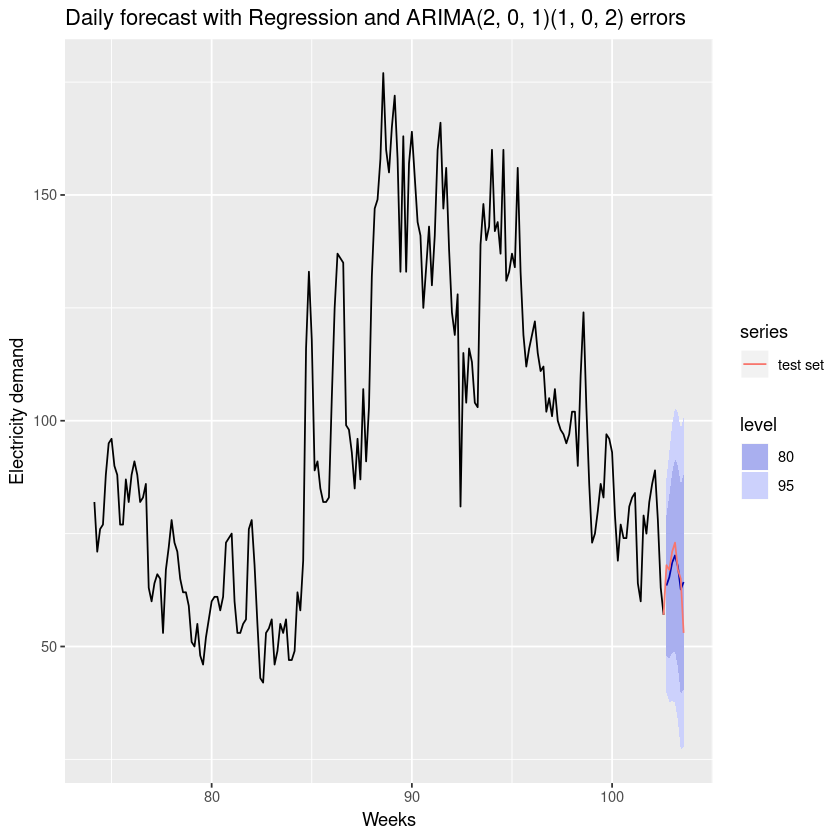

In [303]:
daily.fc.reg <- forecast(daily.fit.reg, xreg=tail(xreg, 7))
autoplot(daily.fc.reg, include = 200) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(daily.test, series="test set") +
    ggtitle("Daily forecast with Regression and ARIMA(2, 0, 1)(1, 0, 2) errors")

In [266]:
accuracy(daily.fc.reg, daily.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.005533916,12.016020,8.702863,-2.1635710,12.154002,0.4632328,-0.006661273,NA
Test set,0.250185505,4.932518,3.683928,-0.3394735,6.056279,0.1960868,-0.083937637,0.8687552


The regression model is probably the model that could best predict this kind of series. One of the problems is that many external predictors are useful for achieving good accuracy, in this case humidity has been used but temperature, dewPoint, pressure and many more could be useful for predicting together maybe with an econometric approach. 